This notebook shows how to use LLM-Geo, you can uncomment a study case (preferred Case 1 and Case 3) to get the spatial analysis results without any human intervention. 

#  Install package

In [194]:
# ! pip install pyvis
# ! pip install networkx

# Import package

In [195]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
import openai
from IPython.display import display, HTML, Code
from IPython.display import clear_output

# Define Solution class
Please run the following cell to define the functions

In [196]:
import LLM_Geo_Constants as constants
import helper

from LLM_Geo_kernel import Solution

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Demonstration Cases

## Input task and data desciption

In [197]:
isReview = True

In [198]:

# Case 1: population living near hazardous wastes

task_name ='Resident_at_risk_counting'
TASK = r"""1) Find out Census tracts that contain hazardous waste facilities, then comppute and print out the population living in those tracts. The study area is North Carolina (NC), US.
2) Generate a population choropleth map for all tract polygons in NC, rendering the color by population; and then highlight the borders of tracts that have hazardous waste facilities. Please draw all polygons, not only the highlighted ones. The map size is 15*10 inches.
"""

DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip.",
                  "NC tract boundary shapefile: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip. The tract ID column is 'GEOID', data types is integer.",
                  "NC tract population CSV file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv. The population is stored in 'TotalPopulation' column. The tract ID column is 'GEOID', data types is integer."
                 ]
 
# # Case 2: France_mobility_changes_2020
# task_name ='France_mobility_changes_2020'
# TASK = r'''
# 1) Show the 2020 human mobility monthly change rates of each administrative regions in a France choropleth map. Each month is a sub-map in a map matrix，12 months in total. All monthly maps need to use the same colorbar range (color scheme: coolwarm). The base of the change rate is January 2020. 
# 2) Draw a line chart to show the monthly change rate trends of all administrative regeions. Each region is a line (the region name is the legend), the x-axis is 2020 months.
# '''

# DATA_LOCATIONS = ["ESRI shapefile for France administrative regions:" + \
#                   "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip. " + \
#                   "The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.",
#                   "REST API url with parameters for daily human mobility data access:" + \
#                   "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020." + \
#                   "The response is in CSV format. There are three columns in the response: " + \
#                   "place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code of every country;" + \
#                   "codes for France administrative regions start with 'FRA'. Use the total intra_movement of the month as the montly mobility.",
#                  ]

# # Case 3: COVID-19 death rate in US
# task_name ='COVID_death_rate'
# TASK = r'''1) Draw a choropleth  map to show the death rate (death/case) of COVID-19 among the countiguous US counties. Use the accumulated COVID-19 data of 2020.12.31 to compute the death rate. Use scheme ='quantiles' when plotting the map.  Set map projection to 'Conus Albers'. Set map size to 15*10 inches.  
# 2) Draw a scatter plot to show the correlation and trend line of the death rate with the senior resident rate, including the r-square and p-value. Set data point transparency to 50%, regression line as red.  Set figure size to 15*10 inches.  
# '''


# DATA_LOCATIONS = [
#                   r"COVID-19 data case in 2020 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv. This data is for daily accumulated COVID cases and deaths for each county in the US. There are 5 columns: date (format: 2021-02-01), county, state, fips, cases, deaths. ",   
#                   r"Contiguous US county boundary (ESRI shapefile): https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip. The county FIPS column is 'GEOID'; map projection is EPSG:4269",
#                   r"Census data (ACS2020): https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv. THe needed columns are: 'FIPS', 'Total Population', 'Total Population: 65 to 74 Years', 'Total Population: 75 to 84 Years', 'Total Population: 85 Years and Over'. Drop rows with NaN cells after loading the used columns.",
#                  ]



# # Case 4: Hospital_accessibility
# task_name ='Hospital_accessibility'
# TASK = r'''
# For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map of zipcode area polygons (unit: km), also show the hospital.
# '''

# DATA_LOCATIONS = [
# r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, the map projection is WGS1984.",
# r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'POINT_X' column, latitude in 'POINT_Y' column.",          
# ]


## Case 5: Census API
# task_name ='Census_API'
# TASK = r''' Show the spatial distribution of the county level median income in the contigous US. Set figure size to (25,15)
# '''

# DATA_LOCATIONS = [
#       "You can use the Census API.",
# ]


# DATA_LOCATIONS = [
# '''Census API key: ae7be70727932dd6aed257692de3f344365d0678'''              
# ]



save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
model=r"gpt-4"
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.graph_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and developer good at Python. You have worked on Geographic 
information science more than 20 years, and know every detail and pitfall when processing spatial data and coding. You have significant experence on graph theory, application, and implementation. You are also experienced on generating map.
 

Your task: Generate a graph (data structure) only, whose nodes are (1) a series of consecutive steps and (2) data to solve this question:  
 1) Find out Census tracts that contain hazardous waste facilities, then comppute and print out the population living in those tracts. The study area is North Carolina (NC), US.
2) Generate a population choropleth map for all tract polygons in NC, rendering the color by population; and then highlight the borders of tracts that have hazardous waste facilities. Please draw all polygons, not only the highlighted ones. The map size is 15*10 inches.
 

Your reply needs to m

## Get graph code from GPT API

In [199]:
response_for_graph = solution.get_LLM_response_for_graph() 
solution.graph_response = response_for_graph
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_graph, language='python'))

import networkx as nx

# Initialize directed graph
G = nx.DiGraph()

# Step 1: Load hazardous waste raw data
G.add_node("haz_waste_shp_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip", description="URL for downloading hazardous waste facility shapefile")
G.add_node("load_haz_waste_shp", node_type="operation", description="Load hazardous waste facility shapefile from the URL")
G.add_edge("haz_waste_shp_url", "load_haz_waste_shp")
G.add_node("haz_waste_gdf", node_type="data", description="GeoDataFrame of hazardous waste facility shapefile loaded from URL")
G.add_edge("load_haz_waste_shp", "haz_waste_gdf")

# Step 2: Load NC tract boundary raw data
G.add_node("nc_tract_shp_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip", description="URL for downloading NC tract boundary shapefile")
G.add_node("load_nc_tract_shp", node_type="operation", description="Load NC tract boundary shapefile from the URL")
G.add_edge("nc_tract_shp_url", "load_nc_tract_shp")
G.add_node("nc_tract_gdf", node_type="data", description="GeoDataFrame of NC tract boundary shapefile loaded from URL")
G.add_edge("load_nc_tract_shp", "nc_tract_gdf")

# Step 3: Load NC tract population data
G.add_node("nc_tract_pop_url", node_type="data", data_path="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv", description="URL for downloading NC tract population in CSV")
G.add_node("load_nc_tract_pop", node_type="operation", description="Load NC tract population data from the URL")
G.add_edge("nc_tract_pop_url", "load_nc_tract_pop")
G.add_node("nc_tract_pop_df", node_type="data", description="DataFrame of NC tract population data loaded from URL")
G.add_edge("load_nc_tract_pop", "nc_tract_pop_df")

# Step 4: Join population to tract gdf
G.add_node("join_pop_to_gdf", node_type="operation", description="Join population data to tract GeoDataFrame")
G.add_edge("nc_tract_gdf", "join_pop_to_gdf")
G.add_edge("nc_tract_pop_df", "join_pop_to_gdf")
G.add_node("pop_tract_gdf", node_type="data", description="Tract GeoDataFrame with joined population data")
G.add_edge("join_pop_to_gdf", "pop_tract_gdf")

# Step 5: find out Hazardous Waste tracts
G.add_node("get_hazardous_tracts", node_type="operation", description="Find out hazardous waste tracts")
G.add_edge("haz_waste_gdf", "get_hazardous_tracts")
G.add_edge("pop_tract_gdf", "get_hazardous_tracts")
G.add_node("hazardous_tracts", node_type="data", description="GefDataFrames of tracts containing hazardous waste facilities")
G.add_edge("get_hazardous_tracts", "hazardous_tracts")

# Step 6: Population in hazardous tracts
G.add_node("get_pop_in_hazardous_tracts", node_type="operation", description="Compute and get population living in hazardous waste tracts")
G.add_edge("hazardous_tracts", "get_pop_in_hazardous_tracts")
G.add_node("pop_in_hazardous_tracts", node_type="data", description="Population living in hazardous waste tracts")
G.add_edge("get_pop_in_hazardous_tracts", "pop_in_hazardous_tracts")

# Step 7: Generate population choropleth map for all tract polygons in NC
G.add_node("gen_choropleth_map", node_type="operation", description="Generate population choropleth map for all tracts in NC and highlight hazardous waste areas")
G.add_edge("pop_tract_gdf", "gen_choropleth_map")
G.add_edge("hazardous_tracts", "gen_choropleth_map")
G.add_node("nc_tract_choropleth_map", node_type="data", description="Population choropleth map for all tract polygons in NC, highlighting hazardous waste areas")
G.add_edge("gen_choropleth_map", "nc_tract_choropleth_map")

# This will not be added to the graph
# Save graph in GraphML format
nx.write_graphml(G, "F:\\Research\\LLM-Geo\\Resident_at_risk_counting\\Resident_at_risk_counting.graphml")

## Execute code to generate the solution graph

In [200]:
exec(solution.code_for_graph)
solution_graph = solution.load_graph_file()

# Show the graph
G = nx.read_graphml(solution.graph_file)  
nt = helper.show_graph(G)
html_name = os.path.join(os.getcwd(), solution.task_name + '.html')  
# HTML file should in the same directory. See:
# https://stackoverflow.com/questions/65564916/error-displaying-pyvis-html-inside-jupyter-lab-cell
nt.show(name=html_name)
# html_name

F:\Research\LLM-Geo\Resident_at_risk_counting.html


## Generate prompts and code for operations (functions)

In [201]:
operations = solution.get_LLM_responses_for_operations(review=isReview)
solution.save_solution()

all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])

clear_output(wait=True)
display(Code(all_operation_code_str, language='python'))

import geopandas as gpd

def load_haz_waste_shp(haz_waste_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip'):
    """
    Description: This function loads a shapefile for hazardous waste facilities from a given URL.

    Args:
        haz_waste_shp_url : str
            The URL from where the shapefile for hazardous waste facilities can be downloaded.

    Returns:
        haz_waste_gdf : GeoDataFrame
            A GeoDataFrame containing information from the loaded shapefile.
    """

    # Load the shapefile from the given URL using GeoPandas
    haz_waste_gdf = gpd.read_file(haz_waste_shp_url)

    return haz_waste_gdf
import geopandas as gpd

def load_nc_tract_shp(nc_tract_shp_url="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip"):
    # Description: Load NC tract boundary shapefile from the URL
    # nc_tract_shp_url: Tract boundary shapefile URL
    
    # Load NC tract boundary Geopandas GeoDataFrame from URL
    nc_tract_gdf = gpd.read_file(nc_tract_shp_url)
    
    return nc_tract_gdf
import pandas as pd

def load_nc_tract_pop(nc_tract_pop_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv'):
    """
    Load NC tract population data from the URL

    Parameters
    ----------
    nc_tract_pop_url : str, optional
        URL for downloading NC tract population in CSV, by default "https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv"

    Returns
    -------
    pandas.DataFrame
        DataFrame of NC tract population data loaded from URL
    """
    
    nc_tract_pop_df = pd.read_csv(nc_tract_pop_url, dtype={'GEOID': int, 'TotalPopulation': int})

    # Drop records with NaN cells in 'GEOID' and 'TotalPopulation' columns
    nc_tract_pop_df = nc_tract_pop_df.dropna(subset=['GEOID', 'TotalPopulation'])

    return nc_tract_pop_df
def join_pop_to_gdf(nc_tract_gdf, nc_tract_pop_df):
    """
    Join population data to tract GeoDataFrame

    Parameters
    ----------
    nc_tract_gdf : geopandas.GeoDataFrame
        GeoDataFrame of NC tract boundary shapefile loaded from URL
    nc_tract_pop_df : pandas.DataFrame
        DataFrame of NC tract population data loaded from URL

    Returns
    -------
    geopandas.GeoDataFrame
        Tract GeoDataFrame with joined population data
    """
    
    # Process the 'GEOID' column in nc_tract_gdf and nc_tract_pop_df before doing the join
    nc_tract_gdf['GEOID'] = nc_tract_gdf['GEOID'].astype(int)
    nc_tract_pop_df['GEOID'] = nc_tract_pop_df['GEOID'].astype(int)

    # Ensure NC tract population DataFrame has unique values in 'GEOID' column before join
    nc_tract_pop_df = nc_tract_pop_df.drop_duplicates('GEOID')

    # Join the population data to the tract gdf using 'GEOID' column
    pop_tract_gdf = nc_tract_gdf.merge(nc_tract_pop_df, how='left', on="GEOID")

    return pop_tract_gdf
import geopandas as gpd

def get_hazardous_tracts(haz_waste_gdf, pop_tract_gdf):
    """
    Find out hazardous waste tracts

    Parameters
    ----------
    haz_waste_gdf : geopandas.GeoDataFrame
        GeoDataFrame of hazardous waste facility shapefile loaded from URL
    pop_tract_gdf : geopandas.GeoDataFrame
        Tract GeoDataFrame with joined population data

    Returns
    -------
    hazardous_tracts : geopandas.GeoDataFrame
        GeoDataFrames of tracts containing hazardous waste facilities
    """
    
    # Check the map projection of haz_waste_gdf and pop_tract_gdf
    haz_waste_crs = haz_waste_gdf.crs
    pop_tract_crs = pop_tract_gdf.crs

    # Convert the map projections of haz_waste_gdf and pop_tract_gdf to the same one
    if haz_waste_crs != pop_tract_crs:
        pop_tract_gdf = pop_tract_gdf.to_crs(haz_waste_crs)

    # Use spatial join to find out tracts containing hazardous waste facilities
    hazardous_tracts_all = gpd.sjoin(pop_tract_gdf, haz_waste_gdf, how="inner", predicate='intersects')

    #

## Generate prompts and code for assembly program

In [202]:
assembly_LLM_response = solution.get_LLM_assembly_response(review=isReview)
solution.assembly_LLM_response = assembly_LLM_response
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_assembly, language='python'))

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

def load_haz_waste_shp(haz_waste_shp_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip'):
    haz_waste_gdf = gpd.read_file(haz_waste_shp_url)
    return haz_waste_gdf

def load_nc_tract_shp(nc_tract_shp_url="https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip"):
    nc_tract_gdf = gpd.read_file(nc_tract_shp_url)
    nc_tract_gdf['GEOID'] = nc_tract_gdf['GEOID'].astype(int)
    return nc_tract_gdf

def load_nc_tract_pop(nc_tract_pop_url='https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv'):
    nc_tract_pop_df = pd.read_csv(nc_tract_pop_url, dtype={'GEOID': int, 'TotalPopulation': int})
    nc_tract_pop_df = nc_tract_pop_df.dropna(subset=['GEOID', 'TotalPopulation'])
    return nc_tract_pop_df

def join_pop_to_gdf(nc_tract_gdf, nc_tract_pop_df):
    nc_tract_pop_df = nc_tract_pop_df.drop_duplicates('GEOID')
    pop_tract_gdf = nc_tract_gdf.merge(nc_tract_pop_df, how='left', on="GEOID")
    return pop_tract_gdf

def get_hazardous_tracts(haz_waste_gdf, pop_tract_gdf):
    haz_waste_crs = haz_waste_gdf.crs
    pop_tract_crs = pop_tract_gdf.crs
    if haz_waste_crs != pop_tract_crs:
        pop_tract_gdf = pop_tract_gdf.to_crs(haz_waste_crs)
    hazardous_tracts_all = gpd.sjoin(pop_tract_gdf, haz_waste_gdf, how="inner", op='intersects')
    hazardous_tracts = hazardous_tracts_all.drop_duplicates(subset='GEOID')
    return hazardous_tracts

def get_pop_in_hazardous_tracts(hazardous_tracts):
    pop_in_hazardous_tracts = hazardous_tracts['TotalPopulation'].sum()
    return pop_in_hazardous_tracts

def gen_choropleth_map(pop_tract_gdf, hazardous_tracts):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    pop_tract_gdf.plot(column='TotalPopulation', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, legend_kwds={'label': "Population", 'orientation': "horizontal"})
    hazardous_tracts.plot(color='red', ax=ax)

    ax.set_title("Population choropleth map for all NC tracts with hazardous waste areas highlighted")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    return fig 

def assembly_solution():
    haz_waste_gdf = load_haz_waste_shp()
    nc_tract_gdf = load_nc_tract_shp()
    nc_tract_pop_df = load_nc_tract_pop()
    pop_tract_gdf = join_pop_to_gdf(nc_tract_gdf, nc_tract_pop_df)

    hazardous_tracts = get_hazardous_tracts(haz_waste_gdf, pop_tract_gdf)
    pop_in_hazardous_tracts = get_pop_in_hazardous_tracts(hazardous_tracts)
    print("The total population in tracts with hazardous sites:", pop_in_hazardous_tracts)
    fig = gen_choropleth_map(pop_tract_gdf, hazardous_tracts)
    plt.savefig('population_choropleth_map.png', dpi=300)

assembly_solution()

## Execute assembly code



-------------- Running code (trial # 1/10) --------------




Complete program:232: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  # operation_dict = function_def.copy()


The total population in tracts with hazardous sites: 5683893


--------------- Done ---------------




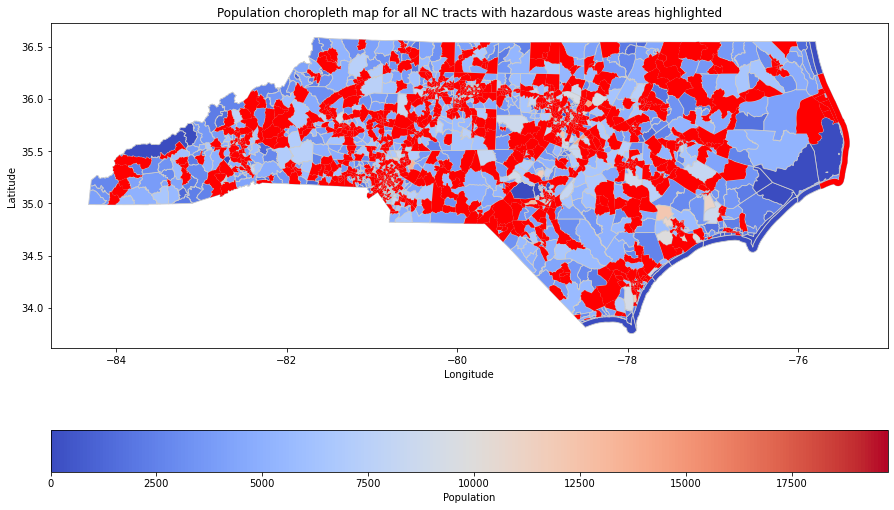

In [203]:
all_code = all_operation_code_str + '\n' + solution.code_for_assembly

# display(Code(all_code, language='python'))

all_code = solution.execute_complete_program(code=all_code, try_cnt=10)